# Create tables/figures for UCI experiments in ICLR submission
In this notebook we'll create the tables and figures for the UCI experiments in the ICRL paper. We logged runs using W&B which were run with:
<!-- ```sh
python train_and_inference.py -m ++wandb.use_wandb=True +experiment=australian_uci,breast_cancer_uci,digits_uci,glass_uci,ionosphere_uci,satellite_uci,vehicle_uci,waveform_uci ++random_seed=101,29,93,17,69
```
```sh
python train_and_inference.py -m ++wandb.use_wandb=True +experiment=australian_uci,breast_cancer_uci,digits_uci,glass_uci,ionosphere_uci,satellite_uci,vehicle_uci,waveform_uci ++random_seed=101,29,93,17,69,68,117,36,187,329
``` -->
<!-- ```sh
python train_and_inference.py -m ++wandb.use_wandb=True +experiment=australian_uci,breast_cancer_uci,digits_uci,glass_uci,ionosphere_uci,satellite_uci,vehicle_uci,waveform_uci ++random_seed=29,68,36,187,329
``` -->
```sh
python train_and_inference.py -m ++wandb.use_wandb=True +experiment=australian_uci,breast_cancer_uci,digits_uci,glass_uci,ionosphere_uci,satellite_uci,vehicle_uci,waveform_uci ++random_seed=68,117,36,187,17 hydra/launcher=lumi_5hrs
```
This submits 5x seeds for each of the 8 UCI data sets. Each job logs test Accuracy, test NLPD, and test ECE for:
- Baselines
    - NN MAP
    - Laplace BNN/GLM with kron/diag Hessian structures both with/without prior precision $\delta$ tuning
    - GP predictive (Immer et al 2021) for M=3200 with/without prior precision $\delta$ tuning
- Ablation
    - SFR for M=1%/2%/5%/10%/15%/20%/40%/60%/80%/100% of N with/without prior precision $\delta$ tuning
    - GP subset for M=1%/2%/5%/10%/15%/20%/40%/60%/80%/100% of N with/without prior precision $\delta$ tuning

In [1]:
import copy
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tikzplotlib
import wandb
from scipy.stats import ttest_ind

/var/folders/m7/4s90cb416f5gppt52n88ddn80000gp/T/ipykernel_62943/3968878420.py:5: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Load data

Either download the runs from W&B (and save as csv) or load data from a csv.

In [2]:
download_runs = False

In [3]:
WANDB_ENTITY = "aalto-ml"
WANDB_PROJECT = "sfr-experiments"

In [4]:
WANDB_RUNS = [
    # Australian
    "rmkfvvou", # seed=117
    "escm5wb8", # seed=36
    "b4olmy84", # seed=17
    "vxl3juse", # seed=187
    "ei3daai7", # seed=68 
    # Breast cancer
    "7uvnv5ih", # seed=117
    "wvq4m8ag", # seed=36
    "uqskhy0g", # seed=17
    "2j2xzzk0", # seed=187
    "9v8jgz4d", # seed=68 
    # Digits
    "m6xlewnb", # seed=117
    "zrz4m0w7", # seed=36
    "00o1czvn", # seed=17
    "xjzwvtt5", # seed=187
    "5wtejpuy", # seed=68 
    # Glass
    "qtdqucoh", # seed=117
    "fczrmy41", # seed=36
    "ezqvq88o", # seed=17
    "9m9ai97h", # seed=187
    "l9reator", # seed=68 
    # Ionosphere
    "yeg2yiik", # seed=117
    "2lahdhi1", # seed=36
    "ujy4gnir", # seed=17
    "ra030cb9", # seed=187
    "vs0utisj", # seed=68
    # Satellite
    "lrlll90x", # seed=117
    "mdxjoasu", # seed=36
    "ycvf0stp", # seed=17
    "58axnjkv", # seed=187
    "44qgjpzc", # seed=68
    # Vehicle
    "eoapfnjg", # seed=117
    "mxud33bw", # seed=36
    "ne8y4mji", # seed=17
    "te2g2psp", # seed=187
    "5zf4emjq", # seed=68
    # Waveform
    "a61o9vtt", # seed=117
    "giw9eozu", # seed=36
    "pynagve9", # seed=17
    "jovevb8d", # seed=187
    "0m5xdnd1", # seed=68
]

In [5]:
def load_table_as_dataframe():
    api = wandb.Api(timeout=19)
    dfs = []
    for run_id in WANDB_RUNS:
        print("Getting data for seed with run_id: {}".format(run_id))
        table_artifact = api.artifact(f"{WANDB_ENTITY}/{WANDB_PROJECT}/run-{run_id}-Metrics:latest")
        table_artifact.download()
        table = table_artifact.get("Metrics")
        df = pd.DataFrame(data=table.data, columns=table.columns)
        dfs.append(df)
    df_all = pd.concat(dfs)
    return df_all

def save_wandb_runs_as_csv(save_path: str = "./csv/uci.csv"):
    df = load_table_as_dataframe()
    df.to_csv(save_path)
    return df

In [6]:
save_path: str = "./csv/uci.csv"

if download_runs:
    df = save_wandb_runs_as_csv(save_path=save_path)
else:
    df = pd.read_csv(save_path)

## Helper functions

In [7]:
def bold_if_significant(row):
    if row["pvalue"] < 0.05:
        # reject the null hypothesis of identical avg NLPDs
        mean = f"{row['mean']:.2f}"
        std = f"{(row['std']):.2f}"
    else:
        mean = "\mathbf{" + f"{row['mean']:.2f}" + "}"
        std = "\mathbf{" + f"{(row['std']):.2f}" + "}"
    if "NN MAP" in row["model"]:
        # don't bold the NN MAP result
        mean = f"{row['mean']:.2f}"
        std = f"{(row['std']):.2f}"
    return "\\val{" + mean + "}{" + std + "}"


def add_num_data(row):
    return NUM_DATAS[row["dataset"]]


def add_num_classes(row):
    return NUM_CLASSES[row["dataset"]]


def add_input_dims(row):
    return INPUT_DIMS[row["dataset"]]


def add_posthoc(row):
    if "BO" in row["model"]:
        return "Prior precision tuning"
    else:
        return "Fixed prior precision"

## Create Table A5 - SFR for uncertainty qunatification (UCI)

In [8]:
DATASETS = {
    "australian": "\sc Australian",
    "breast_cancer": "\sc Breast cancer",
    "ionosphere": "\sc Ionosphere",
    "glass": "\sc Glass",
    "vehicle": "\sc Vehicle",
    "waveform": "\sc Waveform",
    "digits": "\sc Digits",
    "satellite": "\sc Satellite",
}
NUM_DATAS = {
    "australian": 690,
    "breast_cancer": 683,
    "ionosphere": 351,
    "glass": 214,
    "vehicle": 846,
    "waveform": 1000,
    "digits": 1797,
    "satellite": 6435,
}
INPUT_DIMS = {
    "australian": 14,
    "breast_cancer": 10,
    "ionosphere": 34,
    "glass": 9,
    "vehicle": 18,
    "waveform": 21,
    "digits": 64,
    "satellite": 35,
}
NUM_CLASSES = {
    "australian": 2,
    "breast_cancer": 2,
    "ionosphere": 2,
    "glass": 6,
    "vehicle": 4,
    "waveform": 3,
    "digits": 10,
    "satellite": 6,
}

In [9]:
def create_table_a5(df):
    MODELS = [
        "NN MAP",
        "BNN full",
        "GLM full",
        "GP Subset (NN)", # GP predictive
        "GP Subset (GP)",
        "SFR (GP)",
    ]
    
    COLUMNS_TITLES_MULTI = [
        ("$N$", ""),
        ("$D$", ""),
        ("$C$", ""),
        ("\sc nn map", ""),
        ("\sc Laplace", "full"),
        ("\sc Laplace glm", "full"),
        ("{\sc gp} predictive", "$M = 20\% \\text{ of } N$"),
        ("{\sc gp} subset", "$M = 20\% \\text{ of } N$"),
        ("\our", "$M = 20\% \\text{ of } N$"),
    ]
    
    COLUMNS_TITLES_DICT = {
        "NN MAP": "\sc nn map",
        "BNN full": "\sc bnn",
        "GLM full": "\sc glm",
        "GP Subset (NN)": "{\sc gp} predictive",
        "GP Subset (GP)": "{\sc gp} subset",
        "SFR (GP)": "\our",
    }

    # Only keeps models we want in table
    df = df[df["model"].isin(MODELS)]

    # Drop num_inducings we don't want in table
    df = df[df["num_inducing_percent"].isin([20, np.NaN])]

    # Calculate mean and std (over seeds) for each combination of dataset and model
    df_with_stats = (
        df.groupby(["dataset", "model"])
        .agg(
            mean=("nlpd", "mean"),
            std=("nlpd", "std"),
            count=("nlpd", "count"),
        )
        .reset_index()
    )
    # return df_with_stats

    df_with_stats["N"] = df_with_stats.apply(add_num_data, axis=1)
    df_with_stats["D"] = df_with_stats.apply(add_input_dims, axis=1)
    df_with_stats["C"] = df_with_stats.apply(add_num_classes, axis=1)
    df_with_stats["prior_prec_tuning"] = df_with_stats.apply(add_posthoc, axis=1)

    # Calculate pvalues for bolding
    df_with_stats["pvalue"] = np.nan
    df_with_stats["tstatistic"] = np.nan
    best_nlpd = np.inf
    MODELS_WITHOUT_MAP = copy.deepcopy(MODELS)
    MODELS_WITHOUT_MAP.remove("NN MAP")
    for dataset_name in DATASETS.keys():
        print(f"Dataset is {dataset_name}")
        df_dataset = df_with_stats[df_with_stats["dataset"] == dataset_name]
        # Find the best NLPD to use as base for paired t test
        for model_name in MODELS_WITHOUT_MAP:
            print(f"Model is {model_name}")
            # print(df_dataset.loc[df_dataset.model == model_name, "mean"])
            nlpd = df_dataset.loc[df_dataset.model == model_name, "mean"].values[0]
            if nlpd < best_nlpd:
                best_nlpd = nlpd
                best_model_name = model_name
        print(f"Best model is {best_model_name} for {dataset_name}")

        group2 = df[(df["dataset"] == dataset_name) & (df["model"] == best_model_name)]
        assert len(group2) == len(df.seed.unique()) # make sure there's one entry per seed
        for model_name in MODELS:
            group1 = df[(df["dataset"] == dataset_name) & (df["model"] == model_name)]
            assert len(group1) == len(df.seed.unique()) # make sure there's one entry per seed
            if model_name == best_model_name:
                pvalue = np.inf
                t_statistic = np.inf
            else:
                result = ttest_ind(group2["nlpd"], group1["nlpd"])
                t_statistic = result.statistic
                pvalue = result.pvalue
            df_dataset.loc[df_dataset.model == model_name, "tstatistic"] = t_statistic
            df_dataset.loc[df_dataset.model == model_name, "pvalue"] = pvalue
            df_with_stats[df_with_stats["dataset"] == dataset_name] = df_dataset

    # Apply the function to the DataFrame to create the final LaTeX table
    df_with_stats["mean_pm_std"] = df_with_stats.apply(bold_if_significant, axis=1)

    uci_table = df_with_stats.pivot(
        index=["dataset"],
        # index=["dataset", "N", "D", "C"],
        columns="model",
        values="mean_pm_std",
    )
    uci_table["$N$"] = pd.Series(NUM_DATAS.values(), index=uci_table.index)
    uci_table["$D$"] = pd.Series(INPUT_DIMS.values(), index=uci_table.index)
    uci_table["$C$"] = pd.Series(NUM_CLASSES.values(), index=uci_table.index)

    # uci_table.index.names = ["Dataset", "N", "D", "C"]
    uci_table.index.names = ["Dataset"]
    uci_table.index.names = [None]
    # uci_table.index.names = None
    uci_table.rename(index=DATASETS, inplace=True)
    # uci_table = uci_table.reset_index().to_string(index=False)
    uci_table.fillna("-", inplace=True)
    uci_table = uci_table.reindex(
        columns=["$N$", "$D$", "$C$"] + MODELS
    ).rename_axis(columns=None)

    uci_table.columns = pd.MultiIndex.from_tuples(COLUMNS_TITLES_MULTI)

    uci_table.rename(columns=COLUMNS_TITLES_DICT, inplace=True)

    # Print the LaTeX table
    print(uci_table.to_latex(column_format="lccc|c|cccccc", escape=False))

    with open("./tabs/uci_table_no_tuning.tex", "w") as file:
        file.write(
            uci_table.to_latex(
                column_format="lccc|c|cccccc", escape=False, multicolumn_format="c"
            )
        )
    return uci_table

table_a5 = create_table_a5(df)
table_a5

Dataset is australian
Model is BNN full
Model is GLM full
Model is GP Subset (NN)
Model is GP Subset (GP)
Model is SFR (GP)
Best model is SFR (GP) for australian
Dataset is breast_cancer
Model is BNN full
Model is GLM full
Model is GP Subset (NN)
Model is GP Subset (GP)
Model is SFR (GP)
Best model is SFR (GP) for breast_cancer
Dataset is ionosphere
Model is BNN full
Model is GLM full
Model is GP Subset (NN)
Model is GP Subset (GP)
Model is SFR (GP)
Best model is SFR (GP) for ionosphere
Dataset is glass
Model is BNN full
Model is GLM full
Model is GP Subset (NN)
Model is GP Subset (GP)
Model is SFR (GP)
Best model is SFR (GP) for glass
Dataset is vehicle
Model is BNN full
Model is GLM full
Model is GP Subset (NN)
Model is GP Subset (GP)
Model is SFR (GP)
Best model is SFR (GP) for vehicle
Dataset is waveform
Model is BNN full
Model is GLM full
Model is GP Subset (NN)
Model is GP Subset (GP)
Model is SFR (GP)
Best model is SFR (GP) for waveform
Dataset is digits
Model is BNN full
Model 

,$N$,$D$,$C$,\sc nn map,\sc Laplace,\sc Laplace glm,{\sc gp} predictive,{\sc gp} subset,\our
,,,,,full,full,$M = 20\% \text{ of } N$,$M = 20\% \text{ of } N$,$M = 20\% \text{ of } N$
\sc Australian,690,14,2,\val{0.33}{0.08},\val{0.71}{0.02},\val{0.41}{0.03},\val{\mathbf{0.34}}{\mathbf{0.05}},\val{0.42}{0.05},\val{\mathbf{0.33}}{\mathbf{0.07}}
\sc Breast cancer,683,10,2,\val{0.10}{0.04},\val{0.73}{0.06},\val{0.36}{0.05},\val{0.22}{0.01},\val{\mathbf{0.20}}{\mathbf{0.07}},\val{\mathbf{0.16}}{\mathbf{0.02}}
\sc Digits,351,34,2,\val{0.09}{0.01},\val{2.34}{0.02},\val{3.12}{0.22},\val{\mathbf{1.09}}{\mathbf{0.05}},\val{\mathbf{1.10}}{\mathbf{0.06}},\val{\mathbf{1.07}}{\mathbf{0.05}}
\sc Glass,214,9,6,\val{0.94}{0.16},\val{1.79}{0.03},\val{1.65}{0.19},\val{1.12}{0.09},\val{1.21}{0.15},\val{\mathbf{0.86}}{\mathbf{0.11}}
\sc Ionosphere,846,18,4,\val{0.33}{0.06},\val{0.70}{0.02},\val{\mathbf{0.34}}{\mathbf{0.04}},\val{\mathbf{0.34}}{\mathbf{0.05}},\val{0.43}{0.04},\val{\mathbf{0.32}}{\mathbf{0.06}}
\sc Satellite,1000,21,3,\val{0.27}{0.02},\val{1.80}{0.02},\val{0.80}{0.03},\val{0.29}{0.01},\val{0.34}{0.01},\val{\mathbf{0.26}}{\mathbf{0.02}}
\sc Vehicle,1797,64,10,\val{0.35}{0.05},\val{1.39}{0.02},\val{1.52}{0.02},\val{\mathbf{0.77}}{\mathbf{0.03}},\val{0.78}{0.03},\val{\mathbf{0.72}}{\mathbf{0.04}}
\sc Waveform,6435,35,6,\val{0.33}{0.01},\val{1.10}{0.01},\val{1.03}{0.03},\val{0.62}{0.02},\val{0.62}{0.05},\val{\mathbf{0.52}}{\mathbf{0.05}}


## Create Table A4 - UCI classification with prior precision tuning

In [10]:
def add_posthoc(row):
    if "BO" in row["model"]:
        return "Prior precision tuning"
    else:
        return "Fixed prior precision"

def create_table_a4():
    COLUMNS_TITLES = [
        "NN MAP",
        "BNN full",
        "GLM full",
        "GP Subset (GP)",
        "SFR (GP)",
        "BNN full GRID",
        "GLM full GRID",
        "GP Subset (GP) BO",
        "SFR (GP) BO",
    ]
    COLUMNS_TITLES_MULTI = [
        ("$N$", "", ""),
        ("$D$", "", ""),
        ("$C$", "", ""),
        ("\sc nn map", "", ""),
        # ("No $\delta$ tuning", "\sc nn map"),
        ("No $\delta$ tuning", "\sc Laplace", "full"),
        ("No $\delta$ tuning", "\sc Laplace glm", "full"),
        ("No $\delta$ tuning", "{\sc gp} subset", "$M = 20\% \\text{ of } N$"),
        ("No $\delta$ tuning", "\our", "$M = 20\% \\text{ of } N$"),
        ("$\delta$ tuning", "\sc Laplace", "full"),
        ("$\delta$ tuning", "\sc Laplace glm", "full"),
        ("$\delta$ tuning", "{\sc gp} subset", "$M = 20\% \\text{ of } N$"),
        ("$\delta$ tuning", "\our", "$M = 20\% \\text{ of } N$"),
    ]
    COLUMNS_TITLES_DICT = {
        "NN MAP": "\sc nn map",
        "BNN full": "\sc Laplace",
        "GLM full": "\sc Laplace glm",
        "BNN full GRID": "\sc Laplace",
        "GLM full GRID": "\sc Laplace glm",
        # "GP Subest (GP)": "{\sc gp} subset (\sc gp)",
        # "GP Subest (NN)": "{\sc gp} subset (\sc nn)",
        "GP Subset (GP)": "{\sc gp} subset",
        # "GP Subset (NN)": "{\sc gp} subset (\sc nn)",
        "SFR (GP)": "\our",
        # "SFR (NN)": "\our (\sc nn)",
        # "GP Subest (GP) BO": "{\sc gp} subset (\sc gp)",
        "GP Subset (GP) BO": "{\sc gp} subset",
        "SFR (GP) BO": "\our",
    }

    
    # Only keeps models we want in table
    df_ = df[
        df["model"].isin(
            [
                "NN MAP",
                "BNN full",
                "GLM full",
                "GP Subset (GP)",
                "SFR (GP)",
                "BNN full GRID",
                "GLM full GRID",
                "GP Subset (GP) BO",
                "SFR (GP) BO",
            ]
        )
    ]

    # Drop num_inducings we don't want in table
    num_inducings_to_drop = [1, 2, 5, 10, 15, 40, 60, 80, 100]
    for num_inducing in num_inducings_to_drop:
        df_ = df_[df_.num_inducing_percent != num_inducing]

    # return df_
    # Calculate mean and std (over seeds) for each combination of dataset and model
    df_with_stats = (
        df_.groupby(["dataset", "model"])
        .agg(
            mean=("nlpd", "mean"),
            std=("nlpd", "std"),
            count=("nlpd", "count"),
        )
        .reset_index()
    )
    # return df_with_stats

    df_with_stats["N"] = df_with_stats.apply(add_num_data, axis=1)
    df_with_stats["D"] = df_with_stats.apply(add_input_dims, axis=1)
    df_with_stats["C"] = df_with_stats.apply(add_num_classes, axis=1)
    df_with_stats["prior_prec_tuning"] = df_with_stats.apply(add_posthoc, axis=1)

    # Calculate pvalues for bolding
    df_with_stats["pvalue"] = np.nan
    df_with_stats["tstatistic"] = np.nan
    best_nlpd = np.inf
    for dataset_name in DATASETS.keys():
        df_dataset = df_with_stats[df_with_stats["dataset"] == dataset_name]
        # Find the best NLPD to use as base for paired t test
        for model_name in COLUMNS_TITLES:
            nlpd = df_dataset.loc[df_dataset.model == model_name, "mean"].values[0]
            if nlpd < best_nlpd and model_name != "NN MAP":
                best_nlpd = nlpd
                best_model_name = model_name
        print(f"Best model is {best_model_name} for {dataset_name}")

        group2 = df_[(df_["dataset"] == dataset_name) & (df_["model"] == best_model_name)]
        # print(len(group2))
        assert len(group2) == len(df.seed.unique()) # make sure there's one entry per seed
        for model_name in COLUMNS_TITLES:
            group1 = df_[(df_["dataset"] == dataset_name) & (df_["model"] == model_name)]
            # print(len(group1))
            assert len(group1) == len(df.seed.unique())
            if model_name == best_model_name:
                pvalue = np.inf
                t_statistic = np.inf
            else:
                result = ttest_ind(group2["nlpd"], group1["nlpd"])
                t_statistic = result.statistic
                pvalue = result.pvalue
            df_dataset.loc[df_dataset.model == model_name, "tstatistic"] = t_statistic
            df_dataset.loc[df_dataset.model == model_name, "pvalue"] = pvalue
            df_with_stats[df_with_stats["dataset"] == dataset_name] = df_dataset

    # Apply the function to the DataFrame to create the final LaTeX table
    # df_with_stats["pvalue"] = pvalues
    df_with_stats["mean_pm_std"] = df_with_stats.apply(bold_if_significant, axis=1)

    # Reformat the table for paper
    uci_table = df_with_stats.pivot(index=["dataset"], columns="model", values="mean_pm_std")
    uci_table["$N$"] = pd.Series(NUM_DATAS.values(), index=uci_table.index)
    uci_table["$D$"] = pd.Series(INPUT_DIMS.values(), index=uci_table.index)
    uci_table["$C$"] = pd.Series(NUM_CLASSES.values(), index=uci_table.index)

    uci_table.index.names = [None]
    uci_table.rename(index=DATASETS, inplace=True)
    uci_table.fillna("-", inplace=True)
    uci_table = uci_table.reindex(
        columns=["$N$", "$D$", "$C$"] + COLUMNS_TITLES
    ).rename_axis(columns=None)


    uci_table.columns = pd.MultiIndex.from_tuples(COLUMNS_TITLES_MULTI)
    uci_table.rename(columns=COLUMNS_TITLES_DICT, inplace=True)

    # Print the LaTeX table
    print(
        uci_table.to_latex(
            column_format="lccc|c|cccc|cccc", escape=False, multicolumn_format="c"
        )
    )

    with open("./tabs/uci_table_with_prior_prec_tuning.tex", "w") as file:
        file.write(
            uci_table.to_latex(
                column_format="lccc|c|cccc|cccc", escape=False, multicolumn_format="c"
            )
        )
    return uci_table

create_table_a4()

Best model is SFR (GP) for australian
Best model is GLM full GRID for breast_cancer
Best model is GLM full GRID for ionosphere
Best model is GLM full GRID for glass
Best model is GLM full GRID for vehicle
Best model is GLM full GRID for waveform
Best model is GLM full GRID for digits
Best model is GLM full GRID for satellite
\begin{tabular}{lccc|c|cccc|cccc}
\toprule
 & $N$ & $D$ & $C$ & \sc nn map & \multicolumn{4}{c}{No $\delta$ tuning} & \multicolumn{4}{c}{$\delta$ tuning} \\
 &  &  &  &  & \sc Laplace & \sc Laplace glm & {\sc gp} subset & \our & \sc Laplace & \sc Laplace glm & {\sc gp} subset & \our \\
 &  &  &  &  & full & full & $M = 20\% \text{ of } N$ & $M = 20\% \text{ of } N$ & full & full & $M = 20\% \text{ of } N$ & $M = 20\% \text{ of } N$ \\
\midrule
\sc Australian & 690 & 14 & 2 & \val{0.33}{0.08} & \val{0.71}{0.02} & \val{0.41}{0.03} & \val{0.42}{0.05} & \val{\mathbf{0.33}}{\mathbf{0.07}} & \val{\mathbf{0.33}}{\mathbf{0.05}} & \val{\mathbf{0.33}}{\mathbf{0.06}} & \val{0

$N$ $D$ $C$        \sc nn map No $\delta$ tuning  \
                                                         \sc Laplace   
                                                                full   
\sc Australian      690  14   2  \val{0.33}{0.08}   \val{0.71}{0.02}   
\sc Breast cancer   683  10   2  \val{0.10}{0.04}   \val{0.73}{0.06}   
\sc Digits          351  34   2  \val{0.09}{0.01}   \val{2.34}{0.02}   
\sc Glass           214   9   6  \val{0.94}{0.16}   \val{1.79}{0.03}   
\sc Ionosphere      846  18   4  \val{0.33}{0.06}   \val{0.70}{0.02}   
\sc Satellite      1000  21   3  \val{0.27}{0.02}   \val{1.80}{0.02}   
\sc Vehicle        1797  64  10  \val{0.35}{0.05}   \val{1.39}{0.02}   
\sc Waveform       6435  35   6  \val{0.33}{0.01}   \val{1.10}{0.01}   

                                                       \
                                      \sc Laplace glm   
                                                 full   
\sc Australian                       \val{0.41}{0.03}   
\sc Breast cancer                    \val{0.36}{0.05}   
\sc Digits                           \val{3.12}{0.22}   
\sc Glass                            \val{1.65}{0.19}   
\sc Ionosphere     \val{\mathbf{0.34}}{\mathbf{0.04}}   
\sc Satellite                        \val{0.80}{0.03}   
\sc Vehicle                          \val{1.52}{0.02}   
\sc Waveform                         \val{1.03}{0.03}   

                                            \
                           {\sc gp} subset   
                  $M = 20\% \text{ of } N$   
\sc Australian            \val{0.42}{0.05}   
\sc Breast cancer         \val{0.20}{0.07}   
\sc Digits                \val{1.10}{0.06}   
\sc Glass                 \val{1.21}{0.15}   
\sc Ionosphere            \val{0.43}{0.04}   
\sc Satellite             \val{0.34}{0.01}   
\sc Vehicle               \val{0.78}{0.03}   
\sc Waveform              \val{0.62}{0.05}   

                                                       \
                                                 \our   
                             $M = 20\% \text{ of } N$   
\sc Australian     \val{\mathbf{0.33}}{\mathbf{0.07}}   
\sc Breast cancer                    \val{0.16}{0.02}   
\sc Digits                           \val{1.07}{0.05}   
\sc Glass          \val{\mathbf{0.86}}{\mathbf{0.11}}   
\sc Ionosphere     \val{\mathbf{0.32}}{\mathbf{0.06}}   
\sc Satellite      \val{\mathbf{0.26}}{\mathbf{0.02}}   
\sc Vehicle                          \val{0.72}{0.04}   
\sc Waveform                         \val{0.52}{0.05}   

                                      $\delta$ tuning  \
                                          \sc Laplace   
                                                 full   
\sc Australian     \val{\mathbf{0.33}}{\mathbf{0.05}}   
\sc Breast cancer  \val{\mathbf{0.10}}{\mathbf{0.04}}   
\sc Digits                           \val{0.14}{0.02}   
\sc Glass          \val{\mathbf{0.92}}{\mathbf{0.15}}   
\sc Ionosphere     \val{\mathbf{0.36}}{\mathbf{0.04}}   
\sc Satellite                        \val{0.30}{0.01}   
\sc Vehicle        \val{\mathbf{0.37}}{\mathbf{0.04}}   
\sc Waveform       \val{\mathbf{0.33}}{\mathbf{0.01}}   

                                                       \
                                      \sc Laplace glm   
                                                 full   
\sc Australian     \val{\mathbf{0.33}}{\mathbf{0.06}}   
\sc Breast cancer  \val{\mathbf{0.10}}{\mathbf{0.04}}   
\sc Digits         \val{\mathbf{0.10}}{\mathbf{0.01}}   
\sc Glass          \val{\mathbf{0.92}}{\mathbf{0.14}}   
\sc Ionosphere     \val{\mathbf{0.32}}{\mathbf{0.05}}   
\sc Satellite      \val{\mathbf{0.27}}{\mathbf{0.02}}   
\sc Vehicle        \val{\mathbf{0.35}}{\mathbf{0.05}}   
\sc Waveform       \val{\mathbf{0.33}}{\mathbf{0.01}}   

                                                       \
                                      {\sc gp} subset   
                             $M = 20\% \text{ of } N$   
\sc Australian                       

## Create Figure 3 - Num inducing vs NLPD figure

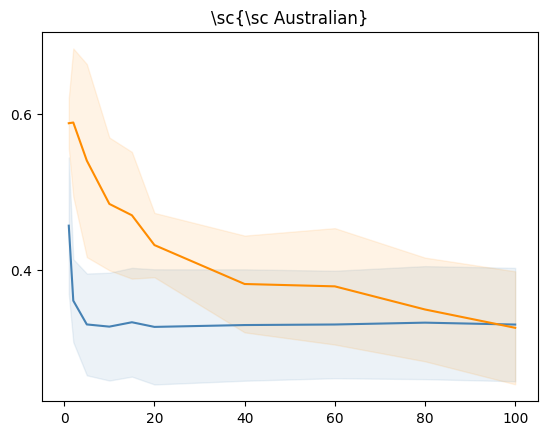

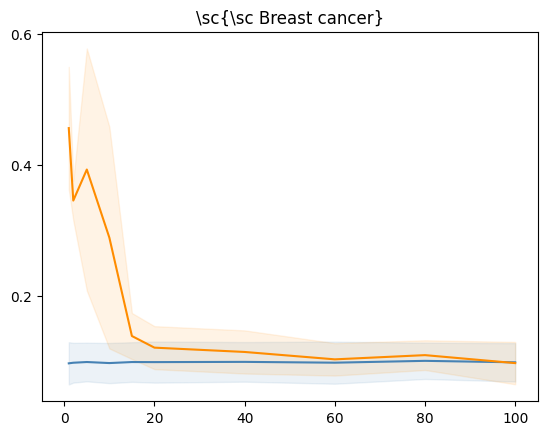

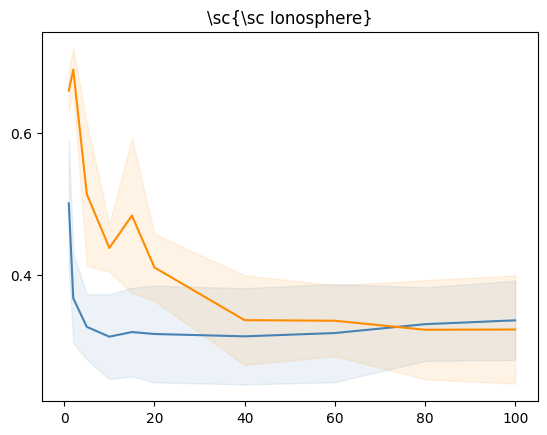

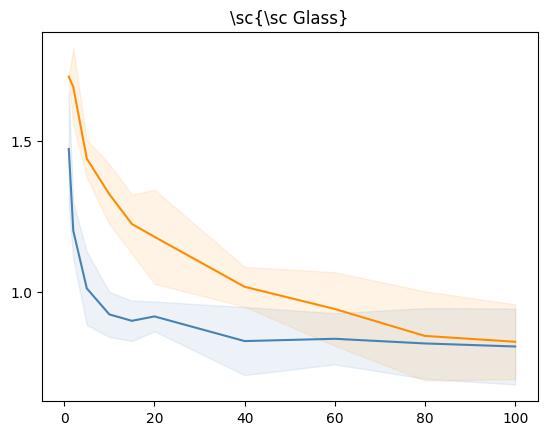

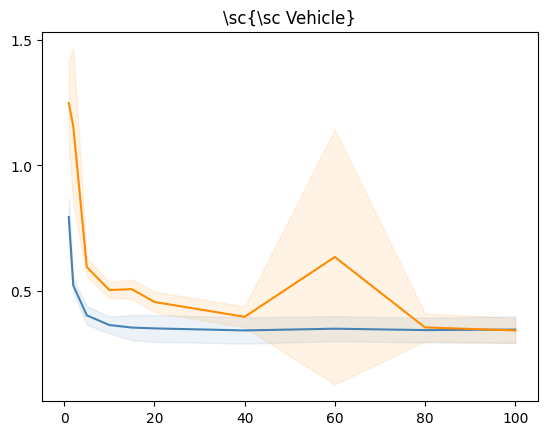

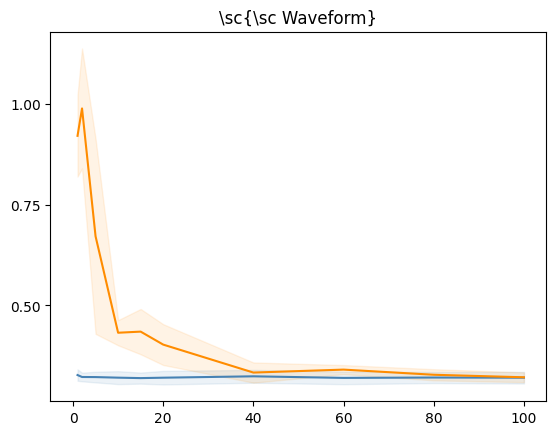

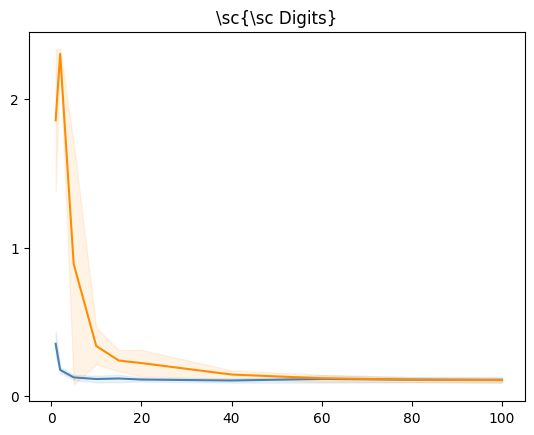

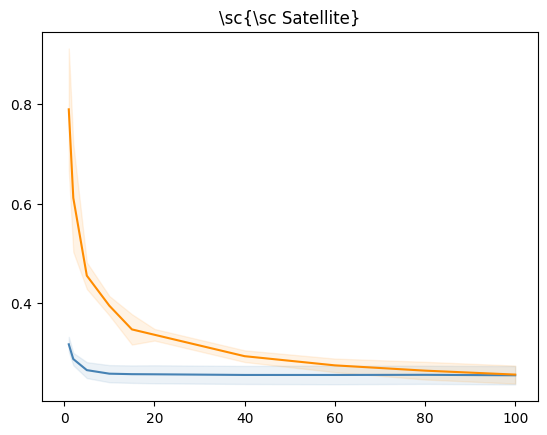

In [11]:
def create_figure_3(df, plot_samples: bool = False, save: bool = False):
    COLORS = {"SFR (GP) BO": "steelblue", "GP Subset (GP) BO": "darkorange"}

    # Remove the vehicle seed which failed
    df = df[~((df["seed"].isin([17])) & (df["dataset"] == "vehicle"))]
    
    # Calculate mean and std (over seeds) for each combination of dataset and model
    df_with_stats = (
        df.groupby(["dataset", "model", "num_inducing_percent"])
        .agg(
            mean=("nlpd", "mean"),
            std=("nlpd", "std"),
            count=("nlpd", "count"),
        )
        .reset_index()
    ) 
    
    for dataset in DATASETS.keys():
        fig, ax = plt.subplots()
        for model_name in COLORS.keys():
            df_model = df_with_stats[(df_with_stats["model"] == model_name) & (df_with_stats["dataset"] == dataset)]
            ax.plot(
                df_model["num_inducing_percent"].to_numpy(),
                df_model["mean"].to_numpy(),
                color=COLORS[model_name],
                label=model_name,
            )
            if plot_samples:
                num_inducing_levels = len(df["num_inducing_percent"].unique()) - 1
                df_ = df[(df["model"] == model_name) & (df["dataset"] == dataset)]
                ax.plot(
                    df_["num_inducing_percent"].to_numpy().reshape(-1, num_inducing_levels).T,
                    df_["nlpd"].to_numpy().reshape(-1, num_inducing_levels).T,
                    # color=COLORS[model_name],
                    label=df_["seed"].to_numpy().reshape(-1, num_inducing_levels)[:, 0],
                )
                ax.legend()
            ax.fill_between(
                df_model["num_inducing_percent"].to_numpy(),
                df_model["mean"].to_numpy() - df_model["std"].to_numpy(),
                df_model["mean"].to_numpy() + df_model["std"].to_numpy(),
                alpha=0.1,
                color=COLORS[model_name],
            )
        plt.locator_params(axis="y", nbins=4)
        ax.set_title("\sc{" + DATASETS[dataset] + "}")
        # ax.set_xlabel("$M$ as % of N")
        # ax.set_xlabel("$\\frac{M}{N} \\times 100$")
        # ax.set_ylabel("NLPD")
        ax.set_xlim(-5, 105)
        if save:
            save_dir = "./figs"
            plt.savefig(os.path.join(save_dir, dataset + ".png"))
            tikzplotlib.save(
                os.path.join(save_dir, dataset + ".tex"),
                axis_width="\\figurewidth",
                axis_height="\\figureheight",
            )

create_figure_3(df, plot_samples=False, save=True)